In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [17]:
CPI = pd.read_csv("CPI_Data/Merged_Data/Merged_CPI.csv")
CPI.set_index('Unnamed: 0', inplace = True)
CPI.index = pd.to_datetime(CPI.index, format = '%Y%m')
CPI.index = pd.DatetimeIndex(CPI.index.values,
                               freq=CPI.index.inferred_freq)
CPI.to_csv('CPI_Data/Clean_Data.csv')
X = CPI['All items']
X = X.dropna()

In [4]:
def Trend_Stationarity(x):

    moving_average = x.rolling(window = 12, center = False).mean()
    moving_std = x.rolling(window = 12, center = False).std()

    plt.plot(x, color = 'blue',label = 'Original Data')
    plt.plot(moving_average, color = 'red', linestyle='-.', label = 'Moving Average')
    plt.plot(moving_std, color ='black', linestyle='--', label = u'Standard Deviation')

    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('CPI Index', fontsize = 18)
    plt.legend(loc='best', fontsize = 15)
    plt.title(u'Moving Average and Standard Deviation', fontsize = 25)
    plt.show()

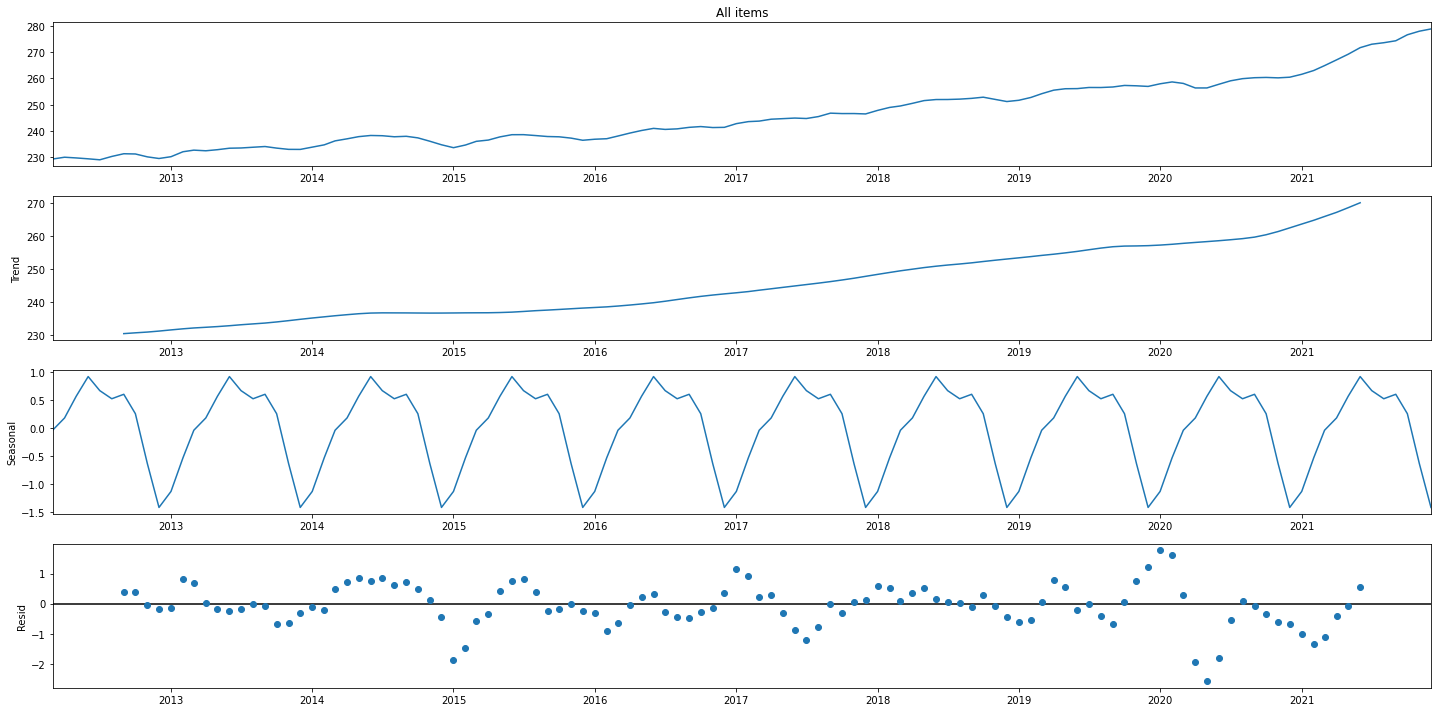

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
decomp = sm.tsa.seasonal_decompose(X, model = 'additive')
fig_all = decomp.plot()
plt.show()

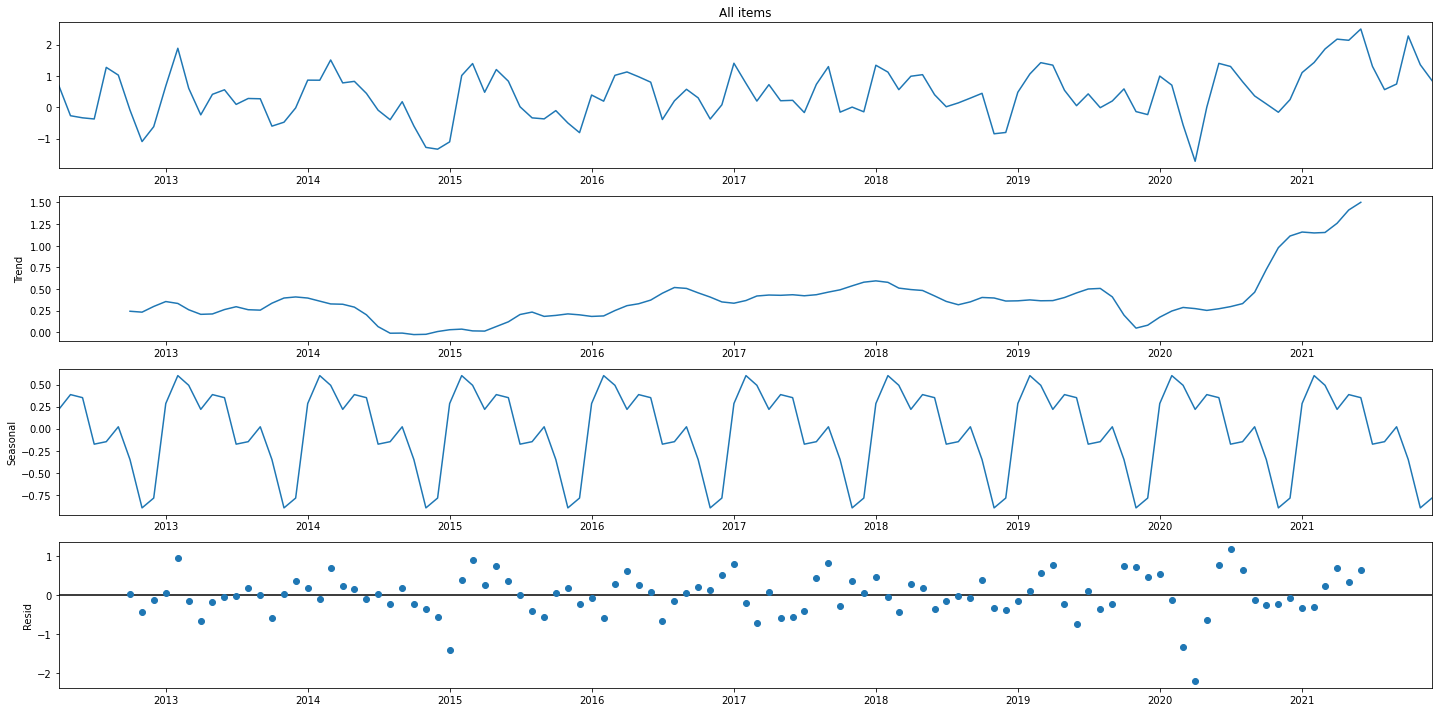

In [6]:
X = X.diff().dropna()
plt.rcParams["figure.figsize"] = (20,10)
decomp = sm.tsa.seasonal_decompose(X, model = 'additive')
fig_all = decomp.plot()
plt.show()

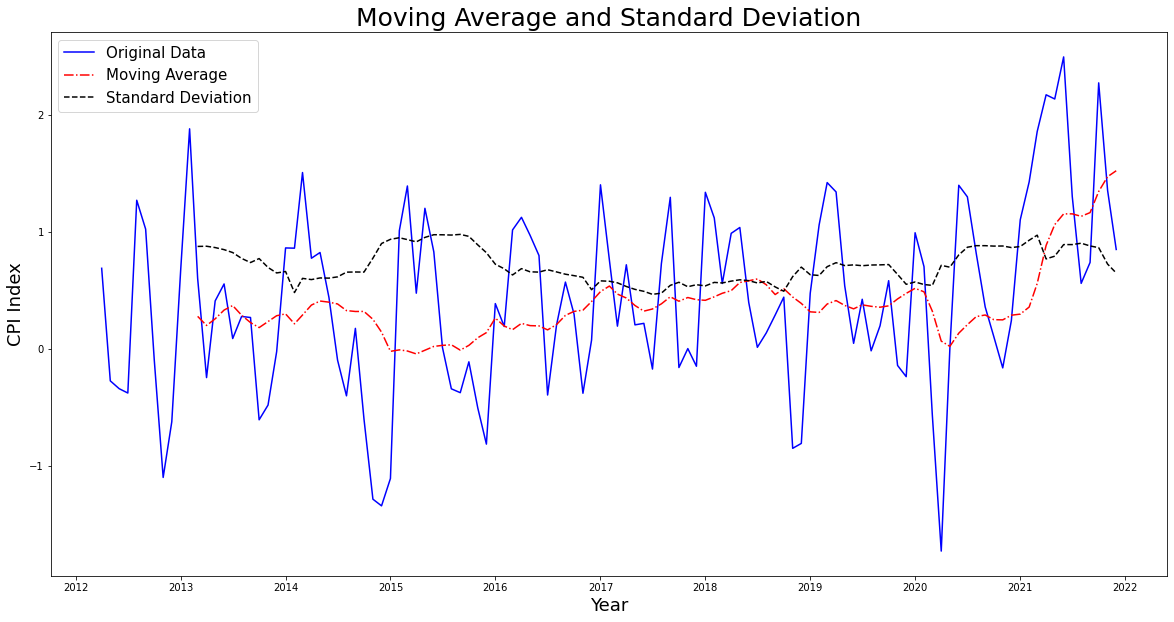

In [7]:
Trend_Stationarity(X)

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
adf_test(X)

1. ADF :  -6.8473989045089105
2. P-Value :  1.7287253469010363e-09
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 115
5. Critical Values :
	 1% :  -3.4885349695076844
	 5% :  -2.887019521656941
	 10% :  -2.5803597920604915


In [9]:
X.shape[0]

117

In [10]:
train_all = X[:-15]
test_all = X[-15:]

In [11]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(X, seasonal=True,
                          suppress_warnings=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  117
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -128.188
Date:                Tue, 12 Apr 2022   AIC                            258.376
Time:                        11:55:04   BIC                            261.130
Sample:                             0   HQIC                           259.494
                                - 117                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5338      0.071      7.550      0.000       0.395       0.672
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.66   Prob(JB):                         0.15
Heteroskedasticity (H):               0.95   Skew:                             0.44
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq_s = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
param_model = []
param_s_model = []
AIC_model = []
model_select = pd.DataFrame()
for param in pdq:
    for param_s in pdq_s:
        model = sm.tsa.statespace.SARIMAX(train_all,order=param,seasonal_order=param_s,enforce_stationarity=False,enforce_invertibility=False)
        model = model.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_s, model.aic))
        param_model.append(param)
        param_s_model.append(param_s)
        AIC_model.append(model.aic)
model_select['pdq'] = param_model
model_select['pdq_x_PDQs'] = param_s_model
model_select['aic'] = AIC_model
print(model_select[model_select['aic'] == model_select['aic'].min()])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:236.6681587739134
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:187.8601622796353
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:204.1076974097968
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:162.09652607014
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:183.1683072274758
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:182.85760869534417
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:174.74945660732126
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:163.32941568864203
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:190.37835569375537
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:159.55427202451594
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:184.95527239374354
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:136.32127680724653
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:158.60558795940577
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:156.17069343617655
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:151.75871432143498
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:141.17681609420077
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:224.09297484740526
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:184.23387111010177
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:

In [13]:
model_all = SARIMAX(train_all, order = (0,0,1), seasonal_order = (0,1,1,12))
model_all = model_all.fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          All items   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -81.038
Date:                            Tue, 12 Apr 2022   AIC                            168.076
Time:                                    11:55:07   BIC                            175.576
Sample:                                04-01-2012   HQIC                           171.101
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5550      0.105      5.277      0.000       0.349       0.761
ma.S.L12      -0.9810      1.948     -0.504      0.615      -4.799       2.837
sigma2         0.2703      0.519      0.521      0.603      -0.747       1.288
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.94   Prob(JB):                         0.02
Heteroskedasticity (H):               1.08   Skew:                            -0.67
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

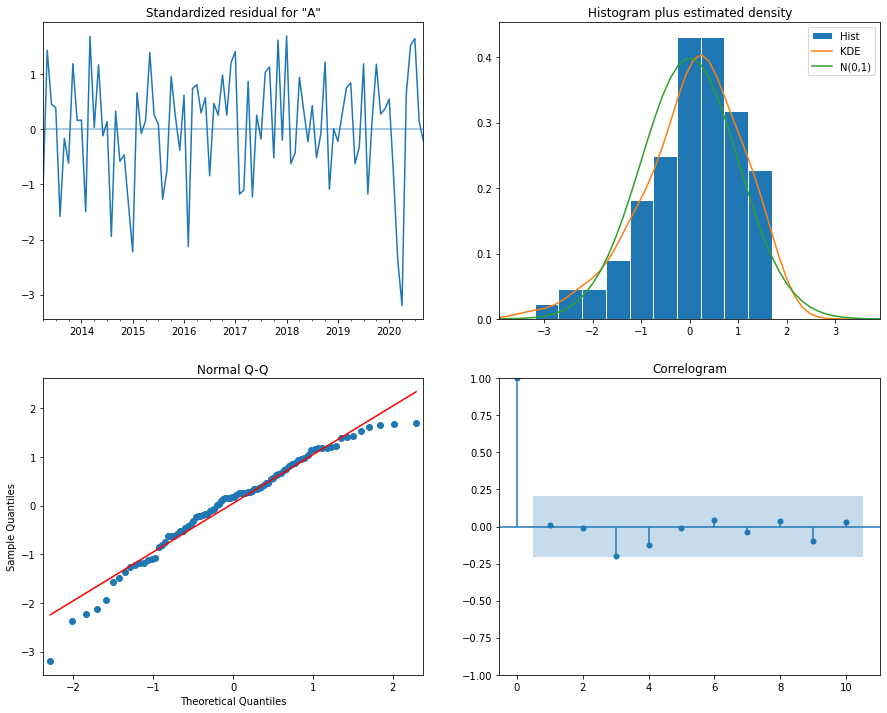

            AC          Q  Prob(>Q)
lag                                
1.0   0.045512   0.217554  0.640910
2.0  -0.114689   1.612881  0.446444
3.0  -0.274455   9.684101  0.021451
4.0  -0.011996   9.699677  0.045802
5.0   0.093010  10.645735  0.058874
6.0   0.059258  11.033760  0.087339
7.0  -0.146882  13.442804  0.062027
8.0  -0.019817  13.487121  0.096152
9.0  -0.001092  13.487257  0.141769
10.0  0.115712  15.031110  0.130932
11.0 -0.021465  15.084822  0.178647
12.0 -0.058561  15.489028  0.215776
13.0  0.046052  15.741808  0.263354
14.0  0.014659  15.767712  0.327765
15.0  0.160565  18.911247  0.217784
16.0 -0.018494  18.953435  0.271085
17.0 -0.072818  19.615174  0.294384
18.0 -0.012760  19.635734  0.353696
19.0  0.009458  19.647167  0.416084
20.0  0.031545  19.775895  0.472025


In [14]:
#Diagnose Model
model_all.plot_diagnostics(figsize=(15, 12))
plt.show()

#LB Test
r,q,p = sm.tsa.acf(model_all.resid.values.squeeze(), qstat=True)
data = np.c_[range(1,21), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

In [15]:
pred_all = model_all.predict(start=0,end=train_all.shape[0],typ='levels').rename('SARIMAX predictions')

<AxesSubplot:>

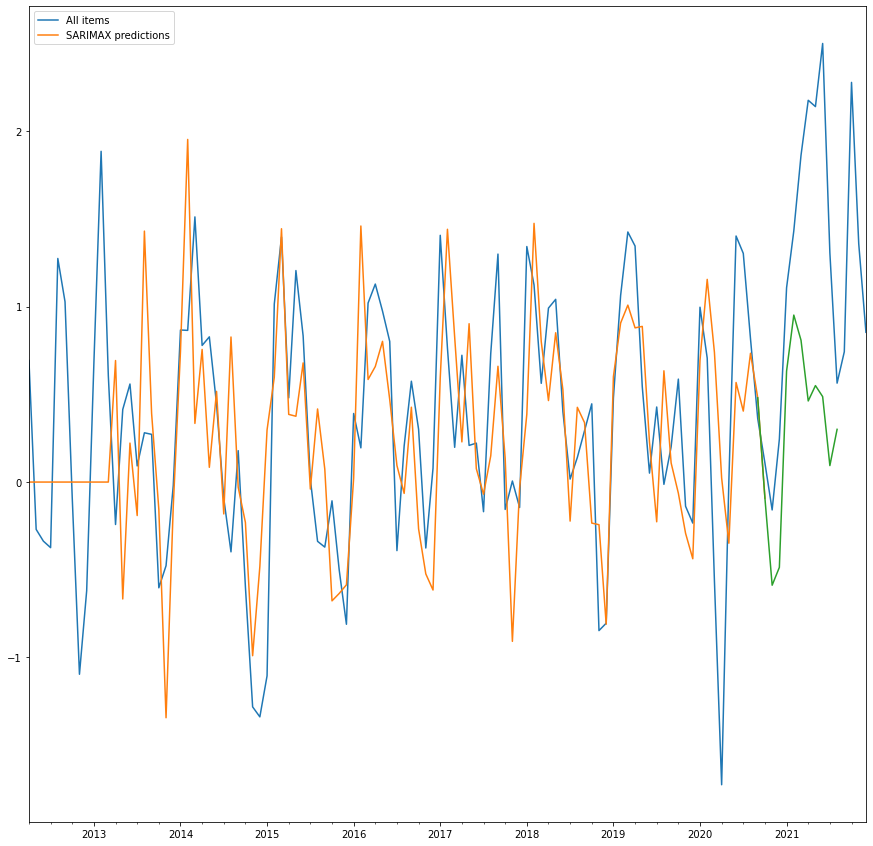

In [16]:
fig_a, ax_a = plt.subplots(1,1, figsize=(15,15))
X.plot(legend = True, ax = ax_a)
pred_all.plot(legend=True, ax=ax_a)

pred_f_a = model_all.predict(start=train_all.shape[0]-1,end=train_all.shape[0]+10,typ='levels').rename('SARIMAX predictions')
pred_f_a.plot()

In [25]:
#Reverse Prediction
pred_t_all = model_all.predict(start=train_all.shape[0],end=train_all.shape[0]+test_all.shape[0]-1,typ='levels').rename('SARIMAX predictions')
last_month_train = CPI['All items'][-16]
# cum sum from last month to initial month
pred_t_all[0] = pred_t_all[0] + last_month_train
pred_t_all = pd.DataFrame(pred_t_all.cumsum())
predicted_index = pd.DataFrame({'index':CPI['All items'].dropna()})
SARIMAX_pred_test = np.concatenate([predicted_index[:-15], pred_t_all], axis=0)
predicted_index['prediction'] = SARIMAX_pred_test
predicted_index.to_csv('CPI_Data/SARIMAX_prediction.csv')
predicted_index


,index,prediction
2012-03-01,229.392,229.392000
2012-04-01,230.085,230.085000
2012-05-01,229.815,229.815000
2012-06-01,229.478,229.478000
2012-07-01,229.104,229.104000
...,...,...
2021-08-01,273.567,263.401478
2021-09-01,274.310,263.827930
2021-10-01,276.589,263.794249
2021-11-01,277.948,263.206019


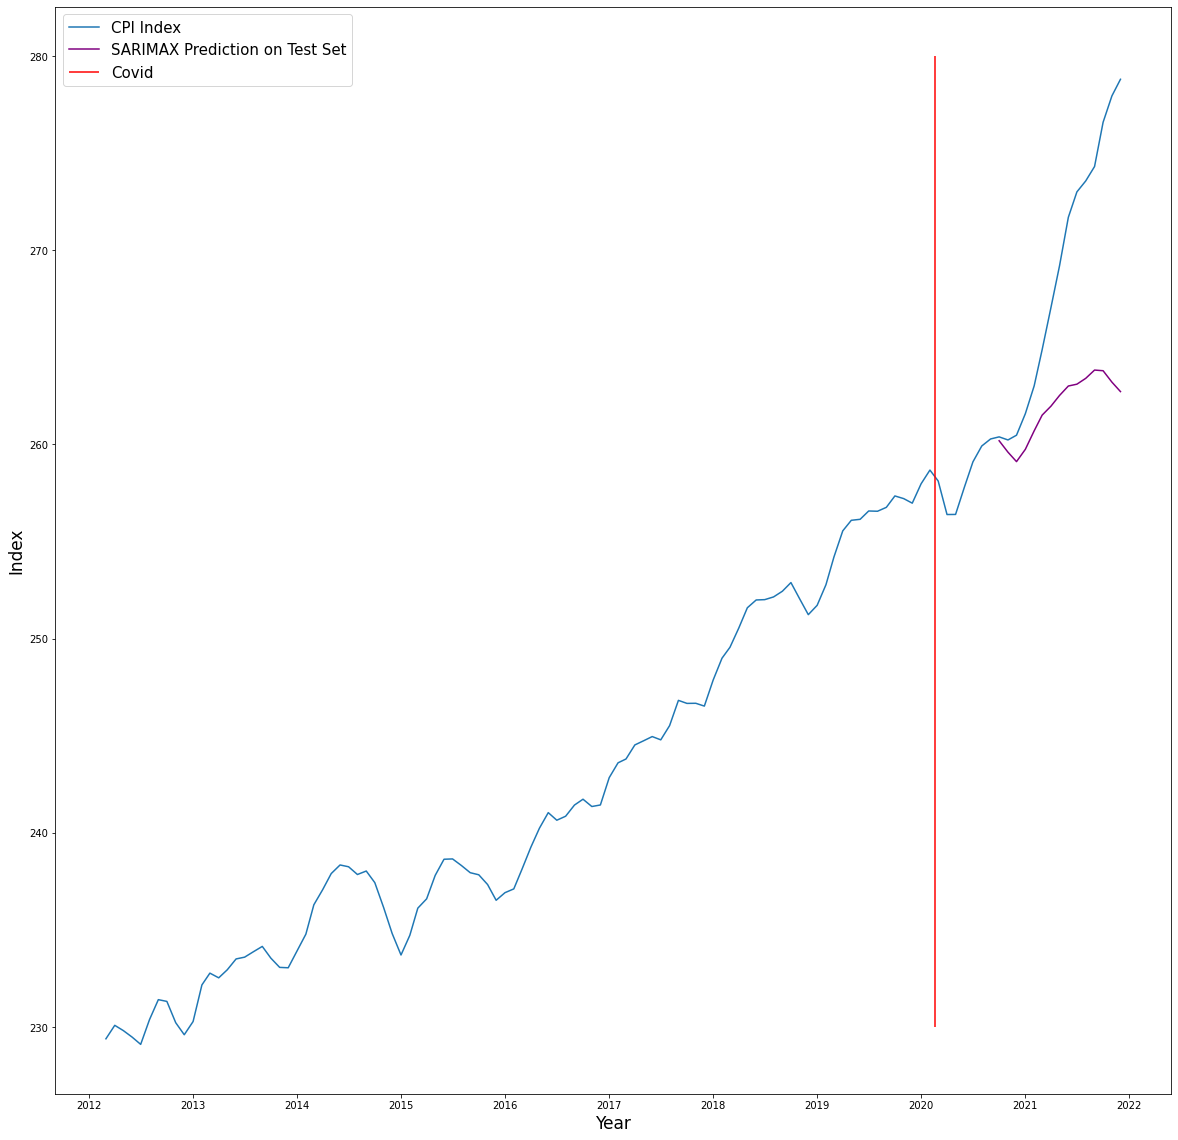

In [18]:
#Plot Train and Test Prediction

fig3, ax3 = plt.subplots(1,1, figsize=(20,20))
ax3.plot(predicted_index['index'], label ='CPI Index')
ax3.plot(predicted_index['prediction'].iloc[train_all.shape[0]+1:], color = 'purple', label = 'SARIMAX Prediction on Test Set')
ax3.vlines(x=pd.to_datetime('2020-02-20', format='%Y-%m-%d'), ymin = 230, ymax=280, colors='r', label='Covid')
ax3.set_xlabel("Year", fontsize = 17)
ax3.set_ylabel("Index", fontsize = 17)
ax3.legend(fontsize = 15)

In [19]:
def evaluation(y, prediction):
    return np.sqrt(sum(y ** 2 - prediction ** 2) / y.shape[0])

In [20]:
y = predicted_index['index'].iloc[train_all.shape[0]:]
y

2020-09-01    260.280
2020-10-01    260.388
2020-11-01    260.229
2020-12-01    260.474
2021-01-01    261.582
2021-02-01    263.014
2021-03-01    264.877
2021-04-01    267.054
2021-05-01    269.195
2021-06-01    271.696
2021-07-01    273.003
2021-08-01    273.567
2021-09-01    274.310
2021-10-01    276.589
2021-11-01    277.948
2021-12-01    278.802
Freq: MS, Name: index, dtype: float64

In [21]:
y_pred = predicted_index['prediction'].iloc[train_all.shape[0]:]
y_pred

2020-09-01    260.280000
2020-10-01    260.187986
2020-11-01    259.599757
2020-12-01    259.113209
2021-01-01    259.746328
2021-02-01    260.698449
2021-03-01    261.507255
2021-04-01    261.969722
2021-05-01    262.519822
2021-06-01    263.006979
2021-07-01    263.100897
2021-08-01    263.401478
2021-09-01    263.827930
2021-10-01    263.794249
2021-11-01    263.206019
2021-12-01    262.719472
Freq: MS, Name: prediction, dtype: float64

In [22]:
print(evaluation(y, y_pred))

59.147838283427916


In [23]:
next_month = model_all.predict(start=train_all.shape[0]+test_all.shape[0],typ='levels')
next_month = predicted_index['prediction'][-1] + next_month
next_month

2022-01-01    263.352591
Freq: MS, dtype: float64